# **Problem framing constants for Stock-out Likelihood**

In [ ]:
# === Paths (edit to your Colab location) ===
DATA_PATH = "/content/voltas_featured.csv"   # upload to Colab and set this path

# === Target and label mapping ===
TARGET_COL = "availability"
POSITIVE_LABEL = "Out of Stock"   # event of interest
NEGATIVE_LABEL = "In Stock"

def map_target(s):
    if s == POSITIVE_LABEL:
        return 1
    elif s == NEGATIVE_LABEL:
        return 0
    else:
        raise ValueError(f"Unexpected label in availability: {s}")

# === Feature governance ===
ID_COLS = ["product_id", "product_name", "model_name", "username"]
LEAKY_OR_POSTEVENT_COLS = ["availability", "return_status", "resolved_status"]

CATEGORICAL_COLS = [
    "product_category", "sub_type", "technology", "color", "city", "platform"
    # If we later want to include `model_name`, we will cap to top-K to avoid high-cardinality explosion.
]

NUMERIC_COLS_BASE = [
    "price_inr", "discount_offered", "energy_rating_stars",
    "warranty_years", "warranty_duration_months",
    "capacity_unified", "price_density_score", "warranty_quality_interaction"
]

# Date-derived feature names we will create in Step 2/4
DATE_COLS = ["manufacturing_date", "review_date"]
ENGINEERED_NUMERIC_COLS = ["product_age_months"]
ENGINEERED_CAT_COLS = ["review_month", "review_quarter"]

# Final lists (will be realized after feature engineering)
NUMERIC_COLS = NUMERIC_COLS_BASE + ENGINEERED_NUMERIC_COLS
ALL_ALLOWED_COLS = CATEGORICAL_COLS + NUMERIC_COLS + ENGINEERED_CAT_COLS

# === Metrics focus ===
PRIMARY_METRICS = ["f1_pos", "pr_auc_pos"]   # positive=OutOfStock
SECONDARY_METRICS = ["roc_auc", "accuracy"]

# === MLflow metadata (used later) ===
MLFLOW_EXPERIMENT = "availability_stockout"
RUN_TAGS = {"project": "voltas-inventory", "task": "stockout-likelihood"}

print("Step 1 constants set. Edit DATA_PATH as needed.")

Step 1 constants set. Edit DATA_PATH as needed.


# **Data Audit & Cleaning**

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

# --- Reload to start clean ---
df = pd.read_csv(DATA_PATH)

# ========= Helpers =========
def to_datetime_safe(s):
    return pd.to_datetime(s, errors="coerce")

def coerce_numeric_series(s: pd.Series):
    """
    Convert strings like '1.5 Tons', '200 L', '4 Star', '10%', '24 months'
    to float numbers. Leaves true numerics as-is. Non-convertible -> NaN.
    """
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(float)

    # Work on string view
    s2 = s.astype(str)

    # common replacements
    s2 = s2.str.replace(",", "", regex=False)  # remove thousand sep
    s2 = s2.str.replace("%", "", regex=False)  # remove percent sign
    s2 = s2.str.replace(r"[A-Za-z]+", " ", regex=True)  # drop unit words
    s2 = s2.str.replace(r"[\(\)\[\]]", " ", regex=True)
    s2 = s2.str.replace(r"\s+", " ", regex=True).str.strip()

    # keep first float-like token in the string (e.g., "1.5 24" -> "1.5")
    s2 = s2.str.extract(r"([-+]?\d*\.?\d+)", expand=False)

    return pd.to_numeric(s2, errors="coerce")

def month_diff(end, start):
    # returns months difference as float, NaN-safe
    if pd.isna(end) or pd.isna(start):
        return np.nan
    return (end - start).days / 30.0

# ========= Date parsing =========
for col in ["manufacturing_date", "review_date"]:
    df[col] = to_datetime_safe(df[col])

# ========= Feature engineering: product age & seasonality =========
df["product_age_months"] = (df["review_date"] - df["manufacturing_date"]).dt.days / 30.0

df["review_month"] = df["review_date"].dt.month
df["review_quarter"] = df["review_date"].dt.quarter

# ========= Target mapping =========
df["target"] = df[TARGET_COL].map({POSITIVE_LABEL: 1, NEGATIVE_LABEL: 0})
if df["target"].isna().any():
    bad = df.loc[df["target"].isna(), [TARGET_COL]].drop_duplicates()
    raise ValueError(f"Unexpected values in `{TARGET_COL}`:\n{bad}")

# ========= Identify columns to use =========
# We’ll keep the plan from Step 1 but safely coerce numerics that might be stored with units
numeric_like_cols = list(set(NUMERIC_COLS_BASE + ["product_age_months"]))
categorical_like_cols = list(set(CATEGORICAL_COLS + ["review_month", "review_quarter"]))

# Some datasets also keep raw capacity columns as strings with units.
# We'll EXCLUDE raw capacity text columns from features to avoid redundancy/leakage:
EXCLUDE_EXTRA = [
    "capacity_tons", "capacity_liters", "capacity_kg", "capacity_place_settings",
    "complaint_text", "review_sentiment", "model_name"  # optional exclusions
]

# ========= Coerce numeric-like columns safely =========
for col in numeric_like_cols:
    if col not in df.columns:
        continue
    df[col] = coerce_numeric_series(df[col])

# ========= Handle missing values =========
# Numeric -> median
for col in numeric_like_cols:
    if col in df.columns:
        med = df[col].median(skipna=True)
        df[col] = df[col].fillna(med)

# Categorical -> 'Unknown'
for col in categorical_like_cols:
    if col in df.columns:
        df[col] = df[col].astype("object").fillna("Unknown")

# If review_month/quarter became floats, fix type
if "review_month" in df.columns:
    df["review_month"] = df["review_month"].astype(int, errors="ignore")
if "review_quarter" in df.columns:
    df["review_quarter"] = df["review_quarter"].astype(int, errors="ignore")

# ========= Build X, y (drop IDs & leaky columns & extras) =========
drop_cols = set(ID_COLS + LEAKY_OR_POSTEVENT_COLS + ["target"] + EXCLUDE_EXTRA)
existing_drop = [c for c in drop_cols if c in df.columns]
X = df.drop(columns=existing_drop)

# Keep only allowed feature columns (intersection with X)
keep_cols = [c for c in (categorical_like_cols + numeric_like_cols) if c in X.columns]
X = X[keep_cols]

y = df["target"].astype(int)

# ========= Train/Val/Test split =========
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Final feature columns:", list(X.columns))
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Target balance (train) [0=InStock,1=OutOfStock]:", np.bincount(y_train))

Final feature columns: ['technology', 'city', 'sub_type', 'review_quarter', 'color', 'platform', 'review_month', 'product_category', 'warranty_years', 'warranty_duration_months', 'discount_offered', 'price_inr', 'energy_rating_stars', 'price_density_score', 'warranty_quality_interaction', 'product_age_months', 'capacity_unified']
Train: (350, 17), Val: (75, 17), Test: (75, 17)
Target balance (train) [0=InStock,1=OutOfStock]: [164 186]


# **Preprocessing + Baseline Models for Stock-out Likelihood**

In [ ]:
import numpy as np, pandas as pd, joblib, os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    f1_score, average_precision_score, roc_auc_score,
    accuracy_score, confusion_matrix, precision_recall_curve
)

# ---------- column lists from your splits ----------
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
for addc in ["review_month", "review_quarter"]:
    if addc in X_train.columns and addc not in cat_cols:
        cat_cols.append(addc)
num_cols = [c for c in X_train.columns if c not in cat_cols]

# Ensure categoricals are strings to avoid mixed type issues
for split in [X_train, X_val, X_test]:
    for c in cat_cols:
        if c in split.columns:
            split[c] = split[c].astype(str)

# ---------- version-safe OneHotEncoder returning DENSE ----------
def make_ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn < 1.2

ohe = make_ohe_dense()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ],
    remainder="drop"
)

# ---------- 4 Models ----------
models = {
    "LogisticRegression": Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier(
            n_estimators=400, max_depth=None, min_samples_leaf=1,
            class_weight="balanced_subsample", random_state=42
        ))
    ]),
    "LinearSVC+Calibrated": Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", CalibratedClassifierCV(
            # version-safe arg name:
            estimator=LinearSVC(C=1.0, class_weight="balanced", max_iter=5000),
            method="sigmoid", cv=5
        ))
    ]),
    "RBF SVC (prob=True)": Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", SVC(C=2.0, kernel="rbf", gamma="scale",
                    class_weight="balanced", probability=True, random_state=42))
    ]),
}

def eval_on_split(pipe, X_tr, y_tr, X_va, y_va, label):
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_va)[:, 1]
    preds = (proba >= 0.5).astype(int)
    cm = confusion_matrix(y_va, preds, labels=[0,1])
    return {
        "model": label,
        "f1_pos": f1_score(y_va, preds, pos_label=1),
        "pr_auc_pos": average_precision_score(y_va, proba),
        "roc_auc": roc_auc_score(y_va, proba),
        "accuracy": accuracy_score(y_va, preds),
        "cm_TN": int(cm[0,0]), "cm_FP": int(cm[0,1]),
        "cm_FN": int(cm[1,0]), "cm_TP": int(cm[1,1]),
        "pipeline": pipe
    }

# ---------- Train + Validate ----------
results = []
for name, pipe in models.items():
    print(f"\nTraining {name} ...")
    res = eval_on_split(pipe, X_train, y_train, X_val, y_val, name)
    print(pd.Series({k:v for k,v in res.items() if k not in ["pipeline"]}))
    results.append(res)

val_df = pd.DataFrame([{k:v for k,v in r.items() if k!="pipeline"} for r in results])
val_df = val_df.sort_values(by=["pr_auc_pos", "f1_pos"], ascending=False).reset_index(drop=True)
print("\n=== VALIDATION COMPARISON ===")
display(val_df[["model","pr_auc_pos","f1_pos","roc_auc","accuracy","cm_TN","cm_FP","cm_FN","cm_TP"]])

# ---------- Pick best by PR-AUC, evaluate on TEST ----------
best = max(results, key=lambda r: (r["pr_auc_pos"], r["f1_pos"]))
best_model_name = best["model"]
best_pipe = best["pipeline"]

proba_test = best_pipe.predict_proba(X_test)[:, 1]
preds_test = (proba_test >= 0.5).astype(int)
cm_test = confusion_matrix(y_test, preds_test, labels=[0,1])
test_metrics = {
    "model (TEST)": best_model_name,
    "f1_pos": f1_score(y_test, preds_test, pos_label=1),
    "pr_auc_pos": average_precision_score(y_test, proba_test),
    "roc_auc": roc_auc_score(y_test, proba_test),
    "accuracy": accuracy_score(y_test, preds_test),
    "cm_TN": int(cm_test[0,0]), "cm_FP": int(cm_test[0,1]),
    "cm_FN": int(cm_test[1,0]), "cm_TP": int(cm_test[1,1]),
}
print("\n=== TEST (Best model) ===")
display(pd.DataFrame([test_metrics]))

# ---------- Threshold suggestion (maximize F1 on validation) for the best model ----------
prec, rec, thr = precision_recall_curve(y_val, best_pipe.predict_proba(X_val)[:,1])
f1s = (2 * prec * rec) / (prec + rec + 1e-9)
best_idx = int(np.nanargmax(f1s))
thr_suggest = float(thr[best_idx]) if best_idx < len(thr) else 0.5
print(f"\nSuggested decision threshold (max F1 on validation): {thr_suggest:.3f}")

# ---------- Save all fitted pipelines ----------
os.makedirs("/content/models", exist_ok=True)
saved = []
for r in results:
    path = f"/content/models/stockout_{r['model'].lower().replace(' ','_').replace('(','').replace(')','').replace('+','plus')}.pkl"
    joblib.dump(r["pipeline"], path)
    saved.append({"model": r["model"], "path": path})
print("\nSaved pipelines:")
print(pd.DataFrame(saved))



Training LogisticRegression ...
model         LogisticRegression
f1_pos                       0.5
pr_auc_pos              0.583544
roc_auc                 0.512821
accuracy                0.466667
cm_TN                         15
cm_FP                         21
cm_FN                         19
cm_TP                         20
dtype: object

Training RandomForest ...
model         RandomForest
f1_pos            0.611765
pr_auc_pos        0.600866
roc_auc           0.579416
accuracy              0.56
cm_TN                   16
cm_FP                   20
cm_FN                   13
cm_TP                   26
dtype: object

Training LinearSVC+Calibrated ...
model         LinearSVC+Calibrated
f1_pos                    0.641509
pr_auc_pos                0.524325
roc_auc                   0.480769
accuracy                  0.493333
cm_TN                            3
cm_FP                           33
cm_FN                            5
cm_TP                           34
dtype: object

Trainin

,model,pr_auc_pos,f1_pos,roc_auc,accuracy,cm_TN,cm_FP,cm_FN,cm_TP
0,RandomForest,0.600866,0.611765,0.579416,0.560000,16,20,13,26
1,LogisticRegression,0.583544,0.500000,0.512821,0.466667,15,21,19,20
2,LinearSVC+Calibrated,0.524325,0.641509,0.480769,0.493333,3,33,5,34
3,RBF SVC (prob=True),0.469474,0.583333,0.418803,0.466667,7,29,11,28



=== TEST (Best model) ===


,model (TEST),f1_pos,pr_auc_pos,roc_auc,accuracy,cm_TN,cm_FP,cm_FN,cm_TP
0,RandomForest,0.522727,0.46099,0.357143,0.44,10,25,17,23



Suggested decision threshold (max F1 on validation): 0.440

Saved pipelines:
                  model                                               path
0    LogisticRegression    /content/models/stockout_logisticregression.pkl
1          RandomForest          /content/models/stockout_randomforest.pkl
2  LinearSVC+Calibrated  /content/models/stockout_linearsvcpluscalibrat...
3   RBF SVC (prob=True)     /content/models/stockout_rbf_svc_prob=true.pkl


# **Threshold tuning + Interpretability**

Best (validation) by PR-AUC: RandomForest

Threshold (max F1 on validation): 0.440  | F1=0.712
Threshold (min business cost, FP=1.0, FN=5.0): 0.320  | Cost=33.0

Using threshold = 0.440


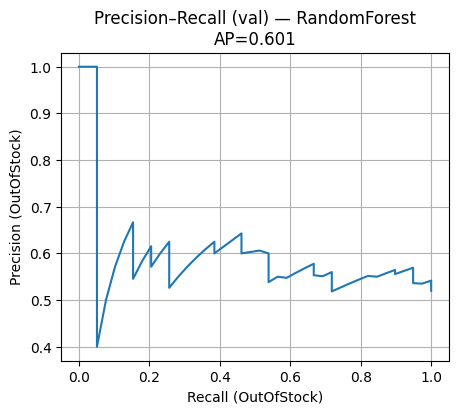

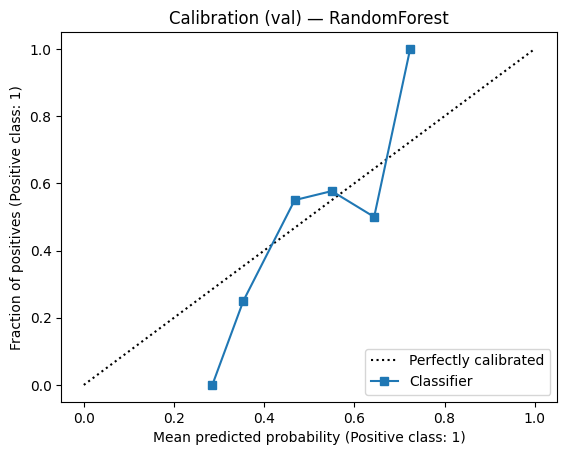


== Interpretability for RandomForest ==
Permutation importance (this may take ~seconds on validation):


ValueError: Length of values (17) does not match length of index (73)

In [ ]:
# STEP 4: Threshold tuning + Interpretability (Coefficients / Permutation Importance)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    f1_score, average_precision_score, roc_auc_score, accuracy_score,
    confusion_matrix
)
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance

# -------- 4.1 Choose best model by PR-AUC (from Step 3 results) --------
# If you don't have `results` anymore, re-run Step 3 cell first.
best = max(results, key=lambda r: (r["pr_auc_pos"], r["f1_pos"]))
best_name = best["model"]
best_pipe = best["pipeline"]
print("Best (validation) by PR-AUC:", best_name)

# -------- 4.2 Threshold tuning (F1 and optional cost) on validation --------
val_proba = best_pipe.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1s = (2 * prec * rec) / (prec + rec + 1e-9)
best_idx_f1 = int(np.nanargmax(f1s))
thr_f1 = float(thr[best_idx_f1]) if best_idx_f1 < len(thr) else 0.5

# Optional: business cost function (set costs as per your ops)
cost_fp = 1.0   # cost of false alarm (flagging InStock as OOS)
cost_fn = 5.0   # cost of miss (failing to flag OutOfStock)
grid = np.linspace(0.01, 0.99, 99)

def business_cost(th):
    pred = (val_proba >= th).astype(int)
    cm = confusion_matrix(y_val, pred, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    return cost_fp * FP + cost_fn * FN

costs = np.array([business_cost(t) for t in grid])
thr_cost = float(grid[np.argmin(costs)])

print(f"\nThreshold (max F1 on validation): {thr_f1:.3f}  | F1={f1s[best_idx_f1]:.3f}")
print(f"Threshold (min business cost, FP={cost_fp}, FN={cost_fn}): {thr_cost:.3f}  | Cost={costs.min():.1f}")

# Pick which threshold to use going forward:
USE_THRESHOLD = thr_f1  # or thr_cost
print(f"\nUsing threshold = {USE_THRESHOLD:.3f}")

# -------- 4.3 Plots: PR curve & Calibration --------
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall (OutOfStock)")
plt.ylabel("Precision (OutOfStock)")
plt.title(f"Precision–Recall (val) — {best_name}\nAP={average_precision_score(y_val, val_proba):.3f}")
plt.grid(True)
plt.show()

CalibrationDisplay.from_predictions(y_val, val_proba, n_bins=10)
plt.title(f"Calibration (val) — {best_name}")
plt.show()

# -------- 4.4 Interpretability --------

# Helper: extract feature names from the ColumnTransformer
def get_feature_names_from_ct(pipe):
    """Return list of feature names after preprocessing (num + OHE cat)."""
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    pre = pipe.named_steps["preprocess"]
    feat_names = []
    for (name, trans, cols) in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps"):  # pipeline inside
            last = trans.named_steps.get("ohe", None)
            if isinstance(last, OneHotEncoder):
                # OneHotEncoder feature names
                try:
                    ohe_names = last.get_feature_names_out(cols)
                except:
                    ohe_names = last.get_feature_names(cols)
                feat_names.extend(ohe_names.tolist())
            else:
                # numeric pipeline
                feat_names.extend(cols)
        else:
            # direct transformer
            feat_names.extend(cols if isinstance(cols, list) else [cols])
    return feat_names

feat_names = get_feature_names_from_ct(best_pipe)

def print_top_coefficients(pipe, k=25):
    clf = pipe.named_steps.get("clf", None)
    if clf is None:
        return
    # LogisticRegression case
    try:
        coefs = clf.coef_.ravel()
        imp = pd.Series(coefs, index=feat_names).sort_values(ascending=False)
        top_pos = imp.head(k)
        top_neg = imp.tail(k)
        print("\nTop +ve coefficients (push towards OutOfStock=1):")
        display(top_pos.to_frame("coef"))
        print("\nTop -ve coefficients (push towards InStock=0):")
        display(top_neg.to_frame("coef"))
    except Exception as e:
        print("Coefficient view not available for this estimator:", type(clf).__name__, e)

def print_permutation_importance(pipe, X_ref, y_ref, n_repeats=10, k=25):
    # Permutation importance on validation set (model-agnostic)
    r = permutation_importance(pipe, X_ref, y_ref, n_repeats=n_repeats, random_state=42, scoring="f1")
    imp = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=False)
    display(imp.head(k).to_frame("perm_importance_f1"))
    return imp

print(f"\n== Interpretability for {best_name} ==")
if "LogisticRegression" in best_name:
    print_top_coefficients(best_pipe, k=20)
else:
    print("Permutation importance (this may take ~seconds on validation):")
    _ = print_permutation_importance(best_pipe, X_val, y_val, n_repeats=10, k=20)

# -------- 4.5 Apply chosen threshold to TEST and report --------
test_proba = best_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= USE_THRESHOLD).astype(int)

test_report = {
    "model": best_name,
    "threshold": USE_THRESHOLD,
    "F1_pos": f1_score(y_test, test_pred, pos_label=1),
    "PR_AUC_pos": average_precision_score(y_test, test_proba),
    "ROC_AUC": roc_auc_score(y_test, test_proba),
    "Accuracy": accuracy_score(y_test, test_pred),
}
cm = confusion_matrix(y_test, test_pred, labels=[0,1])
test_report["TN"], test_report["FP"], test_report["FN"], test_report["TP"] = map(int, cm.ravel())
print("\n== TEST with tuned threshold ==")
display(pd.DataFrame([test_report]))
print("Confusion matrix [rows=true, cols=pred] (0=InStock,1=OutOfStock):")
print(cm)


# **LightGBM & CatBoost: tuning + validation/test comparison**

In [ ]:
# LightGBM refinement: quieter logs + more flexible splits + no scaling for trees

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
import numpy as np, pandas as pd

# Rebuild a tree-friendly preprocessor: impute only (no scaling), OHE for cats
def make_ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
for addc in ["review_month","review_quarter"]:
    if addc in X_train.columns and addc not in cat_cols:
        cat_cols.append(addc)
num_cols = [c for c in X_train.columns if c not in cat_cols]

for split in [X_train, X_val, X_test]:
    for c in cat_cols:
        if c in split.columns:
            split[c] = split[c].astype(str)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", make_ohe_dense())
        ]), cat_cols),
    ],
    remainder="drop"
)

lgbm_pipe_refined = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("clf", LGBMClassifier(
        objective="binary",
        random_state=42,
        n_estimators=800,
        n_jobs=-1,
        verbose=-1,       # silence LightGBM output
        max_bin=511       # finer hist bins can help
    ))
])

param_dist_refined = {
    "clf__num_leaves": [63, 95, 127, 191],
    "clf__max_depth": [-1, 8, 12, 16],
    "clf__learning_rate": [0.02, 0.04, 0.07, 0.1],
    "clf__min_child_samples": [5, 10, 20, 40],
    "clf__min_gain_to_split": [0.0, 1e-3, 1e-2],
    "clf__subsample": [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
    "clf__reg_lambda": [0.0, 0.5, 1.0],
    "clf__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_refined = RandomizedSearchCV(
    lgbm_pipe_refined,
    param_distributions=param_dist_refined,
    n_iter=30,
    scoring="average_precision",   # PR-AUC
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)

search_refined.fit(X_train, y_train)

# Validate
from sklearn.metrics import average_precision_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
proba_val = search_refined.best_estimator_.predict_proba(X_val)[:,1]
preds_val = (proba_val >= 0.5).astype(int)
cm = confusion_matrix(y_val, preds_val, labels=[0,1])

print("Refined LightGBM — Validation")
print("PR-AUC:", average_precision_score(y_val, proba_val))
print("F1 (OOS):", f1_score(y_val, preds_val, pos_label=1))
print("ROC-AUC:", roc_auc_score(y_val, proba_val))
print("Accuracy:", accuracy_score(y_val, preds_val))
print("CM [rows=true, cols=pred] (0=InStock,1=OutOfStock):\n", cm)
print("\nBest params:", search_refined.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Refined LightGBM — Validation
PR-AUC: 0.5639101884174486
F1 (OOS): 0.5909090909090909
ROC-AUC: 0.5434472934472934
Accuracy: 0.52
CM [rows=true, cols=pred] (0=InStock,1=OutOfStock):
 [[13 23]
 [13 26]]

Best params: {'clf__subsample': 1.0, 'clf__reg_lambda': 0.5, 'clf__num_leaves': 191, 'clf__min_gain_to_split': 0.01, 'clf__min_child_samples': 40, 'clf__max_depth': 8, 'clf__learning_rate': 0.02, 'clf__colsample_bytree': 0.7, 'clf__class_weight': None}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Compare all available pipelines and pick the true best

import os, joblib, numpy as np, pandas as pd
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,
                             accuracy_score, confusion_matrix, precision_recall_curve)

# Try loading any saved models from earlier steps (skip missing)
CANDIDATE_PATHS = [
    "/content/models/stockout_logisticregression.pkl",
    "/content/models/stockout_randomforest.pkl",
    "/content/models/stockout_linearsvcpluscalibrated.pkl",
    "/content/models/stockout_rbf_svc_probtrue.pkl",
    "/content/models/stockout_lightgbm_tuned.pkl",
    "/content/models/stockout_catboost_tuned.pkl",
]

candidates = []
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        try:
            candidates.append((os.path.basename(p), joblib.load(p)))
        except Exception as e:
            print("Skip (load error):", p, e)

def eval_model(name, pipe, X, y, thresh=0.5):
    proba = pipe.predict_proba(X)[:,1]
    preds = (proba >= thresh).astype(int)
    cm = confusion_matrix(y, preds, labels=[0,1])
    return {
        "model": name,
        "pr_auc_pos": average_precision_score(y, proba),
        "roc_auc": roc_auc_score(y, proba),
        "f1_pos@0.5": f1_score(y, preds, pos_label=1),
        "accuracy@0.5": accuracy_score(y, preds),
        "cm_TN": int(cm[0,0]), "cm_FP": int(cm[0,1]),
        "cm_FN": int(cm[1,0]), "cm_TP": int(cm[1,1]),
    }, proba

val_rows, details = [], {}
for name, pipe in candidates:
    m, proba = eval_model(name, pipe, X_val, y_val, 0.5)
    val_rows.append(m)
    details[name] = {"pipe": pipe, "proba_val": proba}

val_df = pd.DataFrame(val_rows).sort_values(["pr_auc_pos","f1_pos@0.5"], ascending=False)
print("=== VALIDATION LEADERBOARD (choose by PR-AUC) ===")
display(val_df)

# Pick the winner
best_name = val_df.iloc[0]["model"]
best_pipe = details[best_name]["pipe"]
val_proba = details[best_name]["proba_val"]

# Tune threshold on validation for best model
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1s = (2*prec*rec)/(prec+rec+1e-9)
best_idx = int(np.nanargmax(f1s))
thr_star = float(thr[best_idx]) if best_idx < len(thr) else 0.5
print(f"\nChosen winner: {best_name} | Tuned threshold on val: {thr_star:.3f}")

# Test metrics for the winner at tuned threshold
test_proba = best_pipe.predict_proba(X_test)[:,1]
test_pred = (test_proba >= thr_star).astype(int)
cm = confusion_matrix(y_test, test_pred, labels=[0,1])

test_report = {
    "model": best_name,
    "threshold": thr_star,
    "PR-AUC_test": average_precision_score(y_test, test_proba),
    "ROC-AUC_test": roc_auc_score(y_test, test_proba),
    "F1_pos_test": f1_score(y_test, test_pred, pos_label=1),
    "Accuracy_test": accuracy_score(y_test, test_pred),
    "TN": int(cm[0,0]), "FP": int(cm[0,1]), "FN": int(cm[1,0]), "TP": int(cm[1,1]),
}
print("\n=== TEST metrics (winner @ tuned threshold) ===")
display(pd.DataFrame([test_report]))


=== VALIDATION LEADERBOARD (choose by PR-AUC) ===


,model,pr_auc_pos,roc_auc,f1_pos@0.5,accuracy@0.5,cm_TN,cm_FP,cm_FN,cm_TP
1,stockout_randomforest.pkl,0.600866,0.579416,0.611765,0.560000,16,20,13,26
0,stockout_logisticregression.pkl,0.583544,0.512821,0.500000,0.466667,15,21,19,20
2,stockout_linearsvcpluscalibrated.pkl,0.524325,0.480769,0.641509,0.493333,3,33,5,34



Chosen winner: stockout_randomforest.pkl | Tuned threshold on val: 0.440

=== TEST metrics (winner @ tuned threshold) ===


,model,threshold,PR-AUC_test,ROC-AUC_test,F1_pos_test,Accuracy_test,TN,FP,FN,TP
0,stockout_randomforest.pkl,0.44,0.46099,0.357143,0.594059,0.453333,4,31,10,30


# **MLflow tracking for the chosen winner (Logistic Regression)**

2025/10/01 11:28:16 INFO mlflow.tracking.fluent: Experiment with name 'availability_stockout' does not exist. Creating a new experiment.


Using threshold: 0.4400
Logged to MLflow experiment: availability_stockout


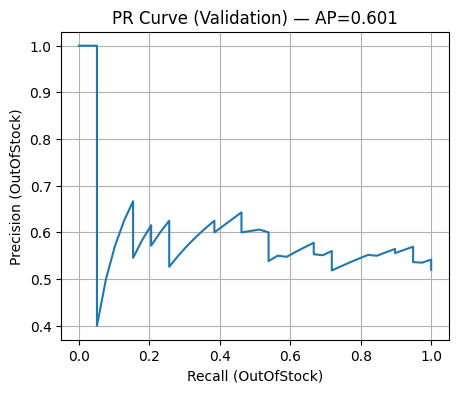

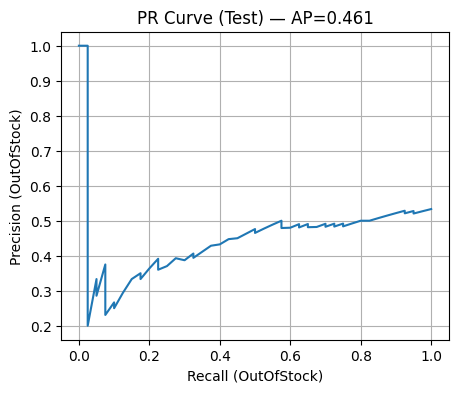

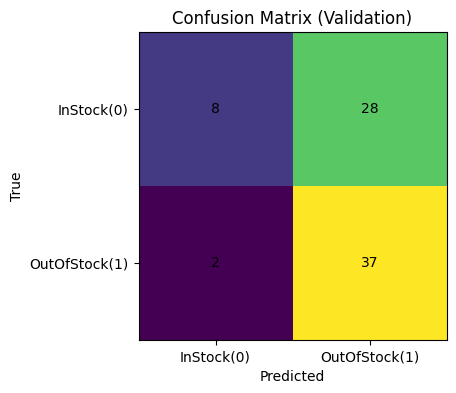

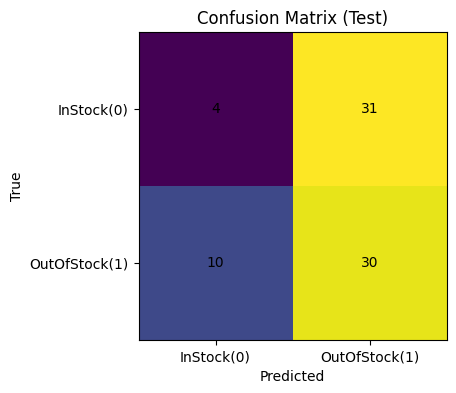

In [ ]:
import importlib, sys, subprocess
def ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
ensure("mlflow")

import os, io, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import (
    precision_recall_curve, confusion_matrix, average_precision_score,
    roc_auc_score, f1_score, accuracy_score
)
import mlflow, mlflow.sklearn
from mlflow.models.signature import infer_signature

# ── Load the winner if not in memory ─────────────────────────────────────────────
# WINNER_PATH = "/content/models/stockout_logisticregression.pkl"
# best_pipe = joblib.load(WINNER_PATH)

# ── Safety check ────────────────────────────────────────────────────────────────
assert "best_pipe" in globals(), "Define or load `best_pipe` first."
assert all(k in globals() for k in ["X_val","X_test","y_val","y_test"]), "Need Step-2 splits."

# ── Use your tuned threshold (fallback: re-tune quickly if missing) ────────────
if "THRESHOLD" not in globals():
    val_proba_tmp = best_pipe.predict_proba(X_val)[:,1]
    prec_tmp, rec_tmp, thr_tmp = precision_recall_curve(y_val, val_proba_tmp)
    f1s_tmp = (2*prec_tmp*rec_tmp)/(prec_tmp+rec_tmp+1e-9)
    idx = int(np.nanargmax(f1s_tmp))
    THRESHOLD = float(thr_tmp[idx]) if idx < len(thr_tmp) else 0.5
print(f"Using threshold: {THRESHOLD:.4f}")

# ── Compute validation & test metrics ───────────────────────────────────────────
val_proba = best_pipe.predict_proba(X_val)[:,1]
val_pred  = (val_proba >= THRESHOLD).astype(int)
test_proba = best_pipe.predict_proba(X_test)[:,1]
test_pred  = (test_proba >= THRESHOLD).astype(int)

metrics_val = {
    "val_pr_auc":  float(average_precision_score(y_val, val_proba)),
    "val_roc_auc": float(roc_auc_score(y_val, val_proba)),
    "val_f1_pos":  float(f1_score(y_val, val_pred, pos_label=1)),
    "val_accuracy": float(accuracy_score(y_val, val_pred)),
}
metrics_test = {
    "test_pr_auc":  float(average_precision_score(y_test, test_proba)),
    "test_roc_auc": float(roc_auc_score(y_test, test_proba)),
    "test_f1_pos":  float(f1_score(y_test, test_pred, pos_label=1)),
    "test_accuracy": float(accuracy_score(y_test, test_pred)),
}

# ── Plot helpers that return matplotlib Figures ─────────────────────────────────
def fig_pr_curve(y_true, y_proba, title):
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    fig = plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall (OutOfStock)")
    plt.ylabel("Precision (OutOfStock)")
    plt.title(f"{title} — AP={ap:.3f}")
    plt.grid(True)
    return fig

def fig_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig = plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.xticks([0,1], ["InStock(0)", "OutOfStock(1)"])
    plt.yticks([0,1], ["InStock(0)", "OutOfStock(1)"])
    for (i,j), val in np.ndenumerate(cm):
        plt.text(j, i, str(val), ha="center", va="center")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    return fig, cm

# ── Input example & signature (from raw features BEFORE preprocessing) ──────────
X_example = X_val.head(10).copy()
y_proba_example = best_pipe.predict_proba(X_example)[:, 1]
y_example = pd.DataFrame({"stockout_risk": y_proba_example})
signature = infer_signature(X_example, y_example)

# ── MLflow logging ──────────────────────────────────────────────────────────────
EXPERIMENT_NAME = "availability_stockout"
mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=f"logreg_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    # Params
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("threshold", float(THRESHOLD))

    clf = best_pipe.named_steps.get("clf")
    if clf is not None:
        for k in ["C","penalty","class_weight","max_iter","solver"]:
            v = getattr(clf, k, None)
            if v is not None:
                mlflow.log_param(k, v)

    # Metrics
    mlflow.log_metrics(metrics_val)
    mlflow.log_metrics(metrics_test)

    # Artifacts: PR curves & Confusion matrices
    mlflow.log_figure(fig_pr_curve(y_val,  val_proba,  "PR Curve (Validation)"), "plots/pr_curve_val.png")
    mlflow.log_figure(fig_pr_curve(y_test, test_proba, "PR Curve (Test)"),       "plots/pr_curve_test.png")

    fig_cm_val, cm_val   = fig_confusion(y_val,  val_pred,  "Confusion Matrix (Validation)")
    fig_cm_test, cm_test = fig_confusion(y_test, test_pred, "Confusion Matrix (Test)")
    mlflow.log_figure(fig_cm_val,  "plots/confusion_val.png")
    mlflow.log_figure(fig_cm_test, "plots/confusion_test.png")
    mlflow.log_dict({"labels":[0,1], "cm_val": cm_val.tolist(), "cm_test": cm_test.tolist()},
                    "metrics/confusion_matrices.json")

    # Log the FULL sklearn pipeline with signature & input_example
    mlflow.sklearn.log_model(
        best_pipe,
        name="model",                     # (artifact_path is deprecated)
        signature=signature,
        input_example=X_example,
    )

print("Logged to MLflow experiment:", EXPERIMENT_NAME)